https://blog.paperspace.com/implement-seq2seq-for-text-summarization-keras/

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import json

# Load cornell movie dialog corpus

In [3]:
corpus_df = pd.read_pickle('/Users/lukaszmaczewski/Documents/Learning/DeepNeuralNetworks/keras/data/cornell_movie_dialog_corpus/corpus_df.pkl')

In [4]:
corpus_df = corpus_df.sample(frac = 0.05)

In [5]:
corpus_df.shape

(75377, 2)

In [6]:
corpus_df.head()

,input_seq,output_seq
726609,"[34813, 45965, 60482, 30231, 38228, 21264]","[54501, 26450, 45965, 20621, 31886, 54178]"
1137548,"[26514, 17480, 39879, 37797]","[54501, 26450, 48583, 13022, 25914, 7417, 5450..."
275791,"[17194, 51429, 29730, 19919, 34813]","[54501, 25914, 35197, 29730, 26965, 31563, 253..."
141213,"[56158, 55201, 51877, 33986, 17144]","[54501, 37118, 40865, 24265, 26439, 25914, 451..."
555036,"[24265, 25914, 27081, 19919, 25586, 25212, 265...","[54501, 25914, 54178]"


In [7]:
with open('/Users/lukaszmaczewski/Documents/Learning/DeepNeuralNetworks/keras/data/cornell_movie_dialog_corpus/token2index.json', 'r') as f:
    token2index = json.load(f)
with open('/Users/lukaszmaczewski/Documents/Learning/DeepNeuralNetworks/keras/data/cornell_movie_dialog_corpus/index2token.json', 'r') as f:
    index2token = json.load(f)

In [8]:
max_index = max(list(token2index.values())) + 1

# Pad sequences

In [9]:
from keras.utils import pad_sequences

2023-09-05 23:14:53.475578: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
max_len = 10

In [11]:
input = pad_sequences(corpus_df.input_seq, maxlen = max_len, padding = 'post', truncating = 'post')
output = pad_sequences(corpus_df.output_seq, maxlen = max_len + 1, padding = 'post', truncating = 'post')

In [12]:
input.shape, output.shape

((75377, 10), (75377, 11))

In [13]:
input

array([[34813, 45965, 60482, ...,     0,     0,     0],
       [26514, 17480, 39879, ...,     0,     0,     0],
       [17194, 51429, 29730, ...,     0,     0,     0],
       ...,
       [26514, 43474, 13022, ...,     0,     0,     0],
       [42829,     0,     0, ...,     0,     0,     0],
       [ 4925, 24937,  4925, ..., 31563,  3501, 29453]], dtype=int32)

In [14]:
output

array([[54501, 26450, 45965, ...,     0,     0,     0],
       [54501, 26450, 48583, ..., 58081, 34099, 54178],
       [54501, 25914, 35197, ..., 25914, 35197, 50605],
       ...,
       [54501, 34813, 26251, ...,     0,     0,     0],
       [54501, 34813, 45965, ...,     0,     0,     0],
       [54501,  8678, 54178, ...,     0,     0,     0]], dtype=int32)

# Create model

In [15]:
from keras.utils.vis_utils import plot_model

In [16]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [17]:
embedding_dim = 16
latent_dim = 32

In [18]:
embed_layer = Embedding(max_index, embedding_dim, trainable=True)

In [19]:
# Encoder
## Encoder input
encoder_inputs = Input(shape=(max_len, ))
## Embedding layer
encoder_embedded = embed_layer(encoder_inputs)
## Encoder LSTM
encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
(encoder_output1, state_h, state_c) = encoder_lstm(encoder_embedded)

# Decoder
## Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(max_len, ))
# Embedding layer
decoder_embedded = embed_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = decoder_lstm(decoder_embedded, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(max_index, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 10, 16)       991680      ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 10, 32),     6272        ['embedding[0][0]']          

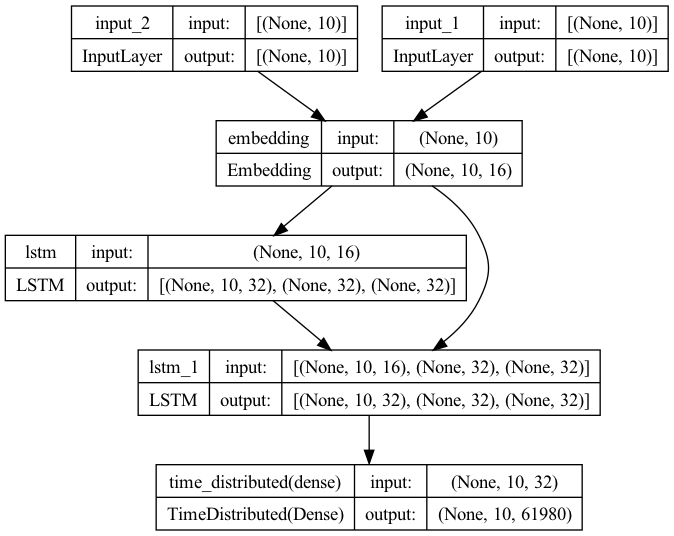

In [20]:
plot_model(model, to_file='model.png', show_shapes=True)

In [21]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [22]:
train_max_index = 70000

In [24]:
history = model.fit([input[:train_max_index], output[:train_max_index,:-1]],
                    output[:train_max_index, 1:],
                    epochs=10,
                    batch_size=128,
                    validation_data = ([input[train_max_index:], output[train_max_index:,:-1]],
                                       output[train_max_index:, 1:])
                   )

Epoch 1/10
547/547 [==============================] - 1086s 2s/step - loss: 6.4130 - val_loss: 5.0964
Epoch 2/10
547/547 [==============================] - 1046s 2s/step - loss: 5.0431 - val_loss: 4.9207
Epoch 3/10
547/547 [==============================] - 1101s 2s/step - loss: 4.6138 - val_loss: 4.4476
Epoch 4/10
547/547 [==============================] - 1047s 2s/step - loss: 4.3614 - val_loss: 4.3062
Epoch 5/10
547/547 [==============================] - 1031s 2s/step - loss: 4.2468 - val_loss: 4.2238
Epoch 6/10
547/547 [==============================] - 1033s 2s/step - loss: 4.1805 - val_loss: 4.1730
Epoch 7/10
547/547 [==============================] - 1040s 2s/step - loss: 4.1327 - val_loss: 4.1312
Epoch 8/10
547/547 [==============================] - 1041s 2s/step - loss: 4.0904 - val_loss: 4.0901
Epoch 9/10
547/547 [==============================] - 1045s 2s/step - loss: 4.0480 - val_loss: 4.0467
Epoch 10/10
547/547 [==============================] - 1045s 2s/step - loss: 4.010

In [43]:
model.save('/Users/lukaszmaczewski/Documents/Learning/DeepNeuralNetworks/keras/models/s2s.keras')

In [124]:
events_from = 100
events_to = 110

In [125]:
tmp = model.predict([input[events_from:events_to,:], output[events_from:events_to,:-1]])

1/1 [==============================] - 0s 99ms/step


In [126]:
tmp.shape

(10, 10, 61980)

In [127]:
import numpy as np

In [128]:
np.argmax(tmp[0,:,:], axis = 1)

array([25914, 45119, 29730, 12703, 12703, 54178, 54178, 26514, 12703,
           0])

In [129]:
index2token.get('0')

In [130]:
for j in input[events_from:events_to,:]:
    print('---')
    for i in j:
        print(index2token.get(str(i)))

---
in
a
better
place
i
hope
None
None
None
None
---
well
if
we
are
like
the
man
invisible
what
are
---
tell
me
miss
saunderswhat
time
does
the
senateuhwhat
do
they
---
what
None
None
None
None
None
None
None
None
None
---
it
is
all
set
my
guy
in
miami
said
he
---
oh
he
was
dying
for
years
None
None
None
None
---
laura
do
you
love
me
None
None
None
None
None
---
the
questions
little
bill
asked
him
what
sort
of
questions
---
what
did
you
do
albert
None
None
None
None
None
---
i
cannot
tell
you
that
None
None
None
None
None


In [131]:
for j in output[events_from:events_to,:]:
    print('---')
    for i in j:
        print(index2token.get(str(i)))

---
<BOS>
you
are
not
gonna
come
back
are
you
<EOS>
None
---
<BOS>
i
do
not
know
uh
i
am
an
artist
i
---
<BOS>
convene
<EOS>
None
None
None
None
None
None
None
None
---
<BOS>
you
know
your
first
campaign
<EOS>
None
None
None
None
---
<BOS>
no
thanks
i
do
not
care
what
you
do
but
---
<BOS>
sure
but
the
end
was
so
sudden
<EOS>
None
None
---
<BOS>
yes
i
love
you
i
have
told
you
but
it
---
<BOS>
about
where
you
ang
him
was
ang
where
you
was
---
<BOS>
nothing
what
could
i
do
<EOS>
None
None
None
None
---
<BOS>
will
she
be
angry
<EOS>
None
None
None
None
None


In [133]:
for j in tmp:
    print('---')
    for i in np.argmax(j, axis = 1):
        print(index2token.get(str(i)))

---
i
am
not
know
know
<EOS>
<EOS>
you
know
None
---
i
am
not
know
<EOS>
<EOS>
am
not
<EOS>
<EOS>
---
i
<EOS>
None
None
None
None
None
None
None
None
---
i
am
<EOS>
little
<EOS>
<EOS>
None
None
None
None
---
i
i
<EOS>
am
not
know
<EOS>
<EOS>
know
not
---
i
<EOS>
you
little
<EOS>
you
<EOS>
<EOS>
None
None
---
i
<EOS>
am
<EOS>
know
am
to
you
know
you
---
i
you
is
know
<EOS>
<EOS>
you
<EOS>
<EOS>
know
---
i
<EOS>
<EOS>
you
am
not
None
None
None
None
---
i
you
<EOS>
<EOS>
<EOS>
None
None
None
None
None
